# Inversion on Unimak Island

This is the noteboook that solves the inversion for the Unimak datasets

## Load libraries

In [1]:
%matplotlib notebook
import numpy as np
import corner
import matplotlib.pyplot as plt
import matplotlib
import h5py
from vmod import util

# Load the downsampled InSAR image

In this step we load the downsampled descending InSAR velocity field and the mask for nan values

In [2]:
mask=np.load('mask_unimak_des.npy')
csvfile='examples/insar/unimak_des_ref.csv'
qmap,extent,rcoords=util.get_defmap(csvfile,mask=mask,trans=False)

# InSAR (descending) data object

Here we load the csv file into an Insar object

In [3]:
from vmod.data import Insar
#xs,ys,azs,lks,los,elos,ref=util.read_dataset_csv('fisher.txt')
#xs,ys,azs,lks,los,elos,ref=util.read_dataset_csv('fisher_ref.txt')
#obs=Insar()
#obs.add_vecs(azs,lks)
#obs.add_xs(xs)
#obs.add_ys(ys)
#obs.add_los(los)
#obs.add_ref(ref)
#obs=util.csv2insar('fisher.txt')
csvfile_ref='examples/insar/unimak_des_ref.csv'
obsin_des=Insar()
obsin_des.importcsv(csvfile,ori=[-164.5,54.7])
#obsin.err=obsin.err*0.0+1.0

# Load GNSS dataset

In this step we load the text file containing the GNSS velocities

In [4]:
csvfile='examples/gps/unimak_gnss_NOAM.txt'
names,lons,lats,uxs,uys,uzs,euxs,euys,euzs=util.read_gnss_csv(csvfile,trans=False)

<IPython.core.display.Javascript object>


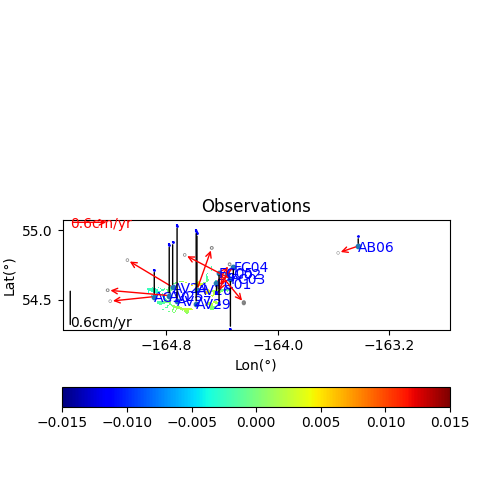

In [5]:
util.plot_gnss(lons,lats,uxs,uys,uzs,'Observations',names,euxs,euys,euzs,scl=0.6,unit='deg')

In [6]:
plt.imshow(qmap,extent=extent,vmin=-0.015,vmax=0.015,cmap='jet')
plt.colorbar(orientation='horizontal')

# InSAR (ascending) data object

Here we load the downsampled InSAR dataset into an Insar object

In [7]:
from vmod.data import Insar

#Creating observation object in this case an 
#InSAR dataset 
obsin_asc=Insar()

#Add azimuth and incidence angles
#obsin_asc.add_vecs(azs,lks)

#Add x and y coordinates
#obsin_asc.add_xs(xs)
#obsin_asc.add_ys(ys)

#Add LOS deformation data
#obsin_asc.add_los(los)

#Add reference point in (x,y) coordinates
#obsin_asc.add_ref(ref)

#Import csv into observation object
csvfile_ref='examples/insar/unimak_asc_ref.csv'
obsin_asc.importcsv(csvfile_ref,ori=[-164.5,54.7])

In [8]:
mask=np.load('mask_unimak_asc.npy')
csvfile='examples/insar/unimak_asc_ref.csv'
qmap,extent,rcoords=util.get_defmap(csvfile,mask=mask,trans=False)

# Plot GNSS dataset with ascending InSAR dataset

In [9]:
csvfile='examples/gps/unimak_gnss_NOAM.txt'
names,lons,lats,uxs,uys,uzs,euxs,euys,euzs=util.read_gnss_csv(csvfile,trans=False)

<IPython.core.display.Javascript object>


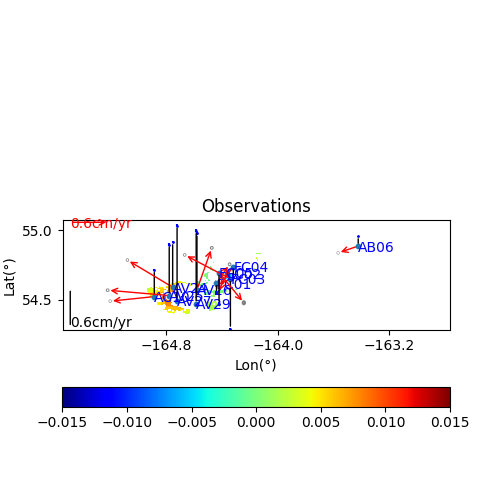

In [10]:
util.plot_gnss(lons,lats,uxs,uys,uzs,'Observations',names,euxs,euys,euzs,scl=0.6,unit='deg')

In [11]:
plt.imshow(qmap,extent=extent,vmin=-0.015,vmax=0.015,cmap='jet')
plt.colorbar(orientation='horizontal')

# Import GNSS dataset into a Gnss object

Here we import the csv file with the GNSS velocities and put it into a Gnss object

In [12]:
from vmod.data import Gnss

#Creating observation object in this case 
#an GNSS dataset 
obsg=Gnss()

#Add the names of the stations
#obsg.add_names(names)

#Add the x and y coordinates 
#of the stations
#obsg.add_xs(xs)
#obsg.add_ys(ys)

#Add deformation dataset in east (uxs), 
#north (uys) and vertical (uzs)
#obsg.add_ux(uxs)
#obsg.add_uy(uys)
#obsg.add_uz(uzs)

#Add uncertainties in east (euxs), 
#north (euys) and vertical (euzs)
#obsg.add_errx(euxs)
#obsg.add_erry(euys)
#obsg.add_errz(euzs)

#Import csv into the observation object
obsg.importcsv(csvfile,ori=[-164.5,54.7])
obsg.add_ref('AB06')

# Defining Joint dataset object

In this step, we create a Joint object with the InSAR dataset (ascending and descending) and the GNSS dataset

In [13]:
from vmod.data import Joint

#Creating observation object in 
#this case a Joint dataset
obs=Joint()

#Adding each dataset object, the 
#user has to provide the relative
#weight of each dataset
#obs.add_dataset(obsin_des,wt=wt_insar)
#obs.add_dataset(obsin_asc,wt=wt_insar)
#obs.add_dataset(obsg,wt=wt_gps)

obsin_asc.add_err(obsin_asc.err*0+1)
obsin_des.add_err(obsin_des.err*0+1)

obs.add_dataset(obsin_des,wt=1.0)
obs.add_dataset(obsin_asc,wt=1.0)
obs.add_dataset(obsg,wt=(len(obsin_des.xs)+len(obsin_asc.xs))/(10*len(obsg.xs)))

# Model and Inverse objects

Here we create the model and inverse objects to run the inversions. We created some auxiliary objects for plotting purposes.

In [14]:
from vmod.source import Mctigue
from vmod.source import Penny
from vmod.source import Okada
from vmod.source import Yang
from vmod.inverse import Inverse

################# Model objects just for plotting##########################################
ygg = Yang(obsg)
ygg.set_x0([10e3,10e3,5e3,-1e5,5e3,1e3,1,1])
#Bounds for parameters
ygg.set_bounds(low_bounds = [0,0,1e3,-5e7,1e3,1e3,0.1,0.1], high_bounds = [20000,20000,15e3,5e7,7e3,7e3,359,89])


mctg = Mctigue(obsg)
mctg.set_x0([-7e3,-7e3,5e3,1e3,3e6])
#Bounds for parameters
mctg.set_bounds(low_bounds = [-20000,-20000,1e3,1e2,-5e7], high_bounds = [0,0,15e3,5e3,5e7])

invg=Inverse(obsg)

invg.register_source(ygg)
invg.register_source(mctg)

#invg.register_source(oksg)

okind_des = Okada(obsin_des)
okind_des.set_type('open')
okind_des.set_x0([15e3,10e3,2e3,12e3,5e2,-0.3,35,89])
#Bounds for parameters
okind_des.set_bounds(low_bounds = [-20000,-20000,1e3,1e1,1e1,-100,1,89], high_bounds = [20000,20000,30e3,3e4,3e4,1,359,89.9])

ygin_des = Yang(obsin_des)
ygin_des.set_x0([10e3,10e3,5e3,-1e5,5e3,1e3,1,1])
#Bounds for parameters
ygin_des.set_bounds(low_bounds = [0,0,1e3,-5e7,1e3,1e3,0.1,0.1], high_bounds = [20000,20000,15e3,5e7,7e3,7e3,359,89])

mctin_des = Mctigue(obsin_des)
mctin_des.set_x0([-7e3,-7e3,5e3,1e3,3e6])
#Bounds for parameters
mctin_des.set_bounds(low_bounds = [-20000,-20000,1e3,1e2,-5e7], high_bounds = [0,0,15e3,5e3,5e7])

invin_des=Inverse(obsin_des)
#invin_des.register_source(okind_des)
invin_des.register_source(ygin_des)
invin_des.register_source(mctin_des)

okind_asc = Okada(obsin_asc)
okind_asc.set_type('open')
okind_asc.set_x0([15e3,10e3,2e3,12e3,5e2,-0.3,35,89])
#Bounds for parameters
okind_asc.set_bounds(low_bounds = [-20000,-20000,1e3,1e1,1e1,-100,1,89], high_bounds = [20000,20000,30e3,3e4,3e4,1,359,89.9])

ygin_asc = Yang(obsin_asc)
ygin_asc.set_x0([10e3,10e3,5e3,-1e5,5e3,1e3,1,1])
#Bounds for parameters
ygin_asc.set_bounds(low_bounds = [-10000,-10000,1e3,-5e7,1e3,1e3,0.1,0.1], high_bounds = [20000,20000,15e3,5e7,7e3,7e3,359,89])

mctin_asc = Mctigue(obsin_asc)
mctin_asc.set_x0([-7e3,-7e3,5e3,1e3,3e6])
#Bounds for parameters
mctin_asc.set_bounds(low_bounds = [-20000,-20000,1e3,1e2,-5e7], high_bounds = [0,0,15e3,5e3,5e7])

invin_asc=Inverse(obsin_asc)

invin_asc.register_source(ygin_asc)
invin_asc.register_source(mctin_asc)

################# Model objects just for plotting##########################################

################# Model objects for Joint dataset##########################################
yg = Yang(obs)
yg.set_x0([10e3,10e3,5e3,-1e6,5e3,1e3,1,1])
#Bounds for parameters
yg.set_bounds(low_bounds = [-3e4,-3e4,1e3,-5e7,1e2,1e2,0.1,0.1], high_bounds = [3e4,3e4,15e3,5e7,20e3,7e3,359,89])

#Creating model object in this case a spherical source
mct = Mctigue(obs)
#Defining the starting point for an inversion 
#The parameters are location (x,y), depth, radius and volume change
mct.set_x0([-7e3,-7e3,5e3,1e3,3e6])
#Bounds for parameters
mct.set_bounds(low_bounds = [-3e4,-3e4,1e3,1e2,-5e7], high_bounds = [3e4,3e4,15e3,5e3,5e7])

inv=Inverse(obs)

inv.register_source(yg)
inv.register_source(mct)
################# Model objects for Joint dataset##########################################

# Non-linear least squares inversion

In this step we run the non-linear least squares inversion and print the results

In [15]:
ans=inv.nlsq()

parnames,orders=inv.get_parnames_orders()
for i,parname in enumerate(parnames):
    print(parname,ans.x[i])

0.05482128816756747
xcen0 9186.449501546931
ycen0 -2820.7831378235906
depth0 4926.695787583856
pressure0 -23337.698753025616
a0 7366.976828858628
b0 4926.695136779388
az0 37.9196020015358
dip0 22.305765097927605
xcen1 -9573.657609075583
ycen1 -19911.866781562134
depth1 7160.302643934469
radius1 1291.0492733249773
dP1 2902520.367303948


## Plotting results from nlsq

Here we use the auxiliary objects to plot the results from the nlsq inversion

In [16]:
los_des=invin_des.forward(ans.x)
los_asc=invin_asc.forward(ans.x)

<IPython.core.display.Javascript object>


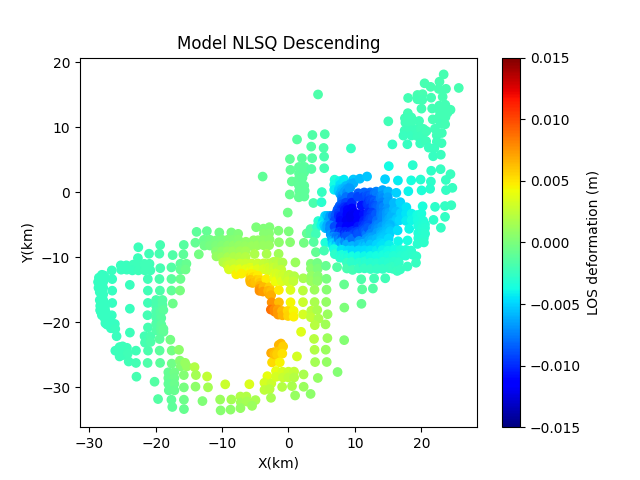

<IPython.core.display.Javascript object>


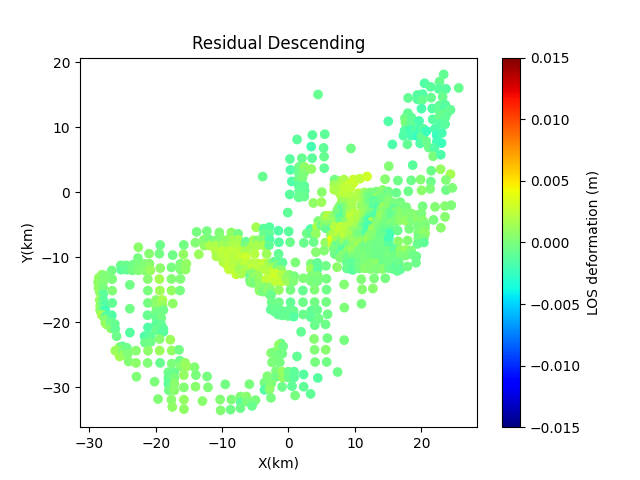

In [17]:
plt.figure()
plt.title('Model NLSQ Descending')
plt.scatter(obsin_des.xs/1e3,obsin_des.ys/1e3,c=los_des,cmap='jet',vmin=-0.015,vmax=0.015)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (m)')

plt.figure()
plt.title('Residual Descending')
plt.scatter(obsin_des.xs/1e3,obsin_des.ys/1e3,c=obsin_des.get_data()-los_des,cmap='jet',vmin=-0.015,vmax=0.015)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (m)')

<IPython.core.display.Javascript object>


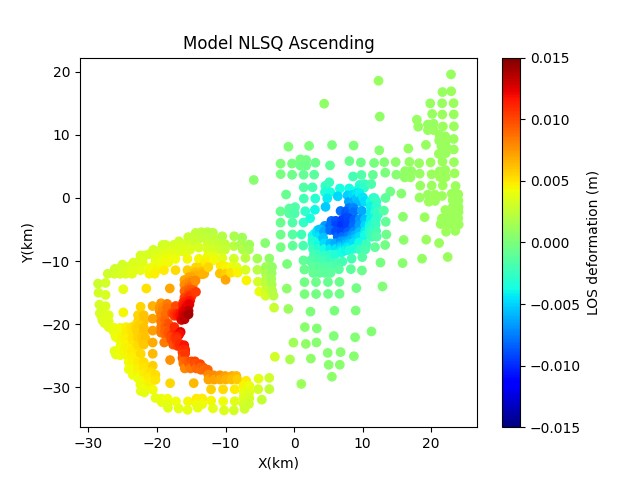

<IPython.core.display.Javascript object>


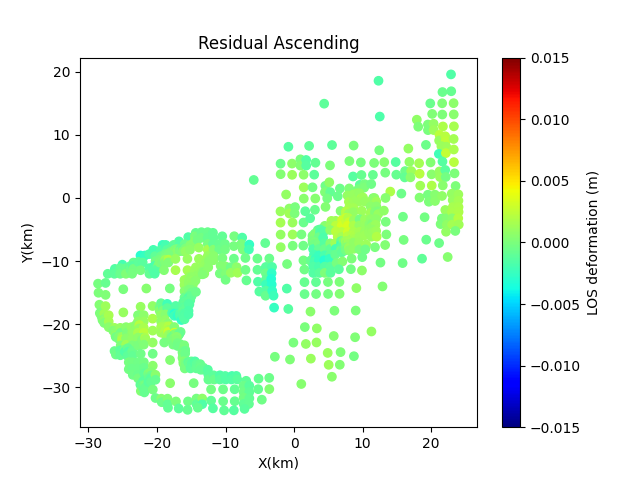

In [18]:
plt.figure()
plt.title('Model NLSQ Ascending')
plt.scatter(obsin_asc.xs/1e3,obsin_asc.ys/1e3,c=los_asc,cmap='jet',vmin=-0.015,vmax=0.015)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (m)')

plt.figure()
plt.title('Residual Ascending')
plt.scatter(obsin_asc.xs/1e3,obsin_asc.ys/1e3,c=obsin_asc.get_data()-los_asc,cmap='jet',vmin=-0.015,vmax=0.015)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (m)')

<IPython.core.display.Javascript object>


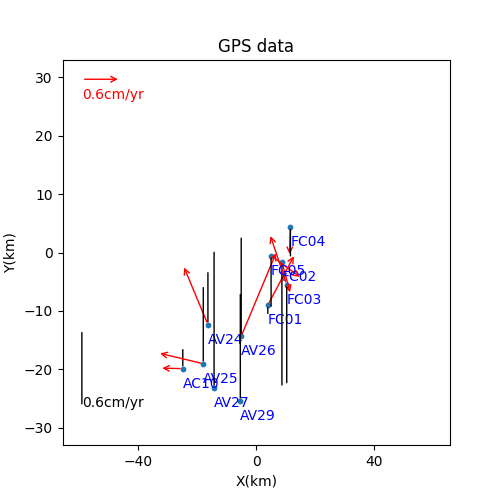

<IPython.core.display.Javascript object>


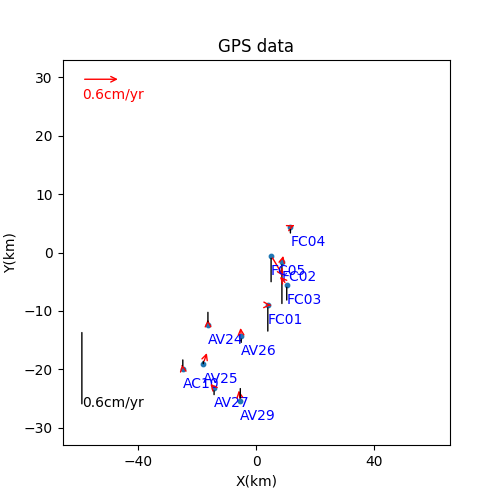

In [19]:
uxsm,uysm,uzsm=invg.forward(ans.x,unravel=False)

uxs,uys,uzs=obsg.get_data(unravel=False)

util.plot_gnss(obsg.xs,obsg.ys,uxsm,uysm,uzsm,names=names,scl=0.6)

util.plot_gnss(obsg.xs,obsg.ys,uxs-uxsm,uys-uysm,uzs-uzsm,names=names,scl=0.6)

# Bayesian inversion

When we run the next cell the Bayesian inversion will start

In [ ]:
#trace,MDL=inv.mcmc('unimak_joint_emc_NOAM_dP2')

 [----------       27%                  ] 1842937 of 6600000 complete in 54636.4 sec

The traces from the Bayesian inversion are stored in a .pkl file

In [20]:
import pickle
with open('unimak_joint_emc_NOAM_dP2.pkl','rb') as handle:
    dic=pickle.load(handle)

trace=[dic[key] for key in dic.keys()]

## Plotting results from Bayesian inversion

Here we use the corner library to plot the posterior distributions and we use the auxiliary objects to plot the results

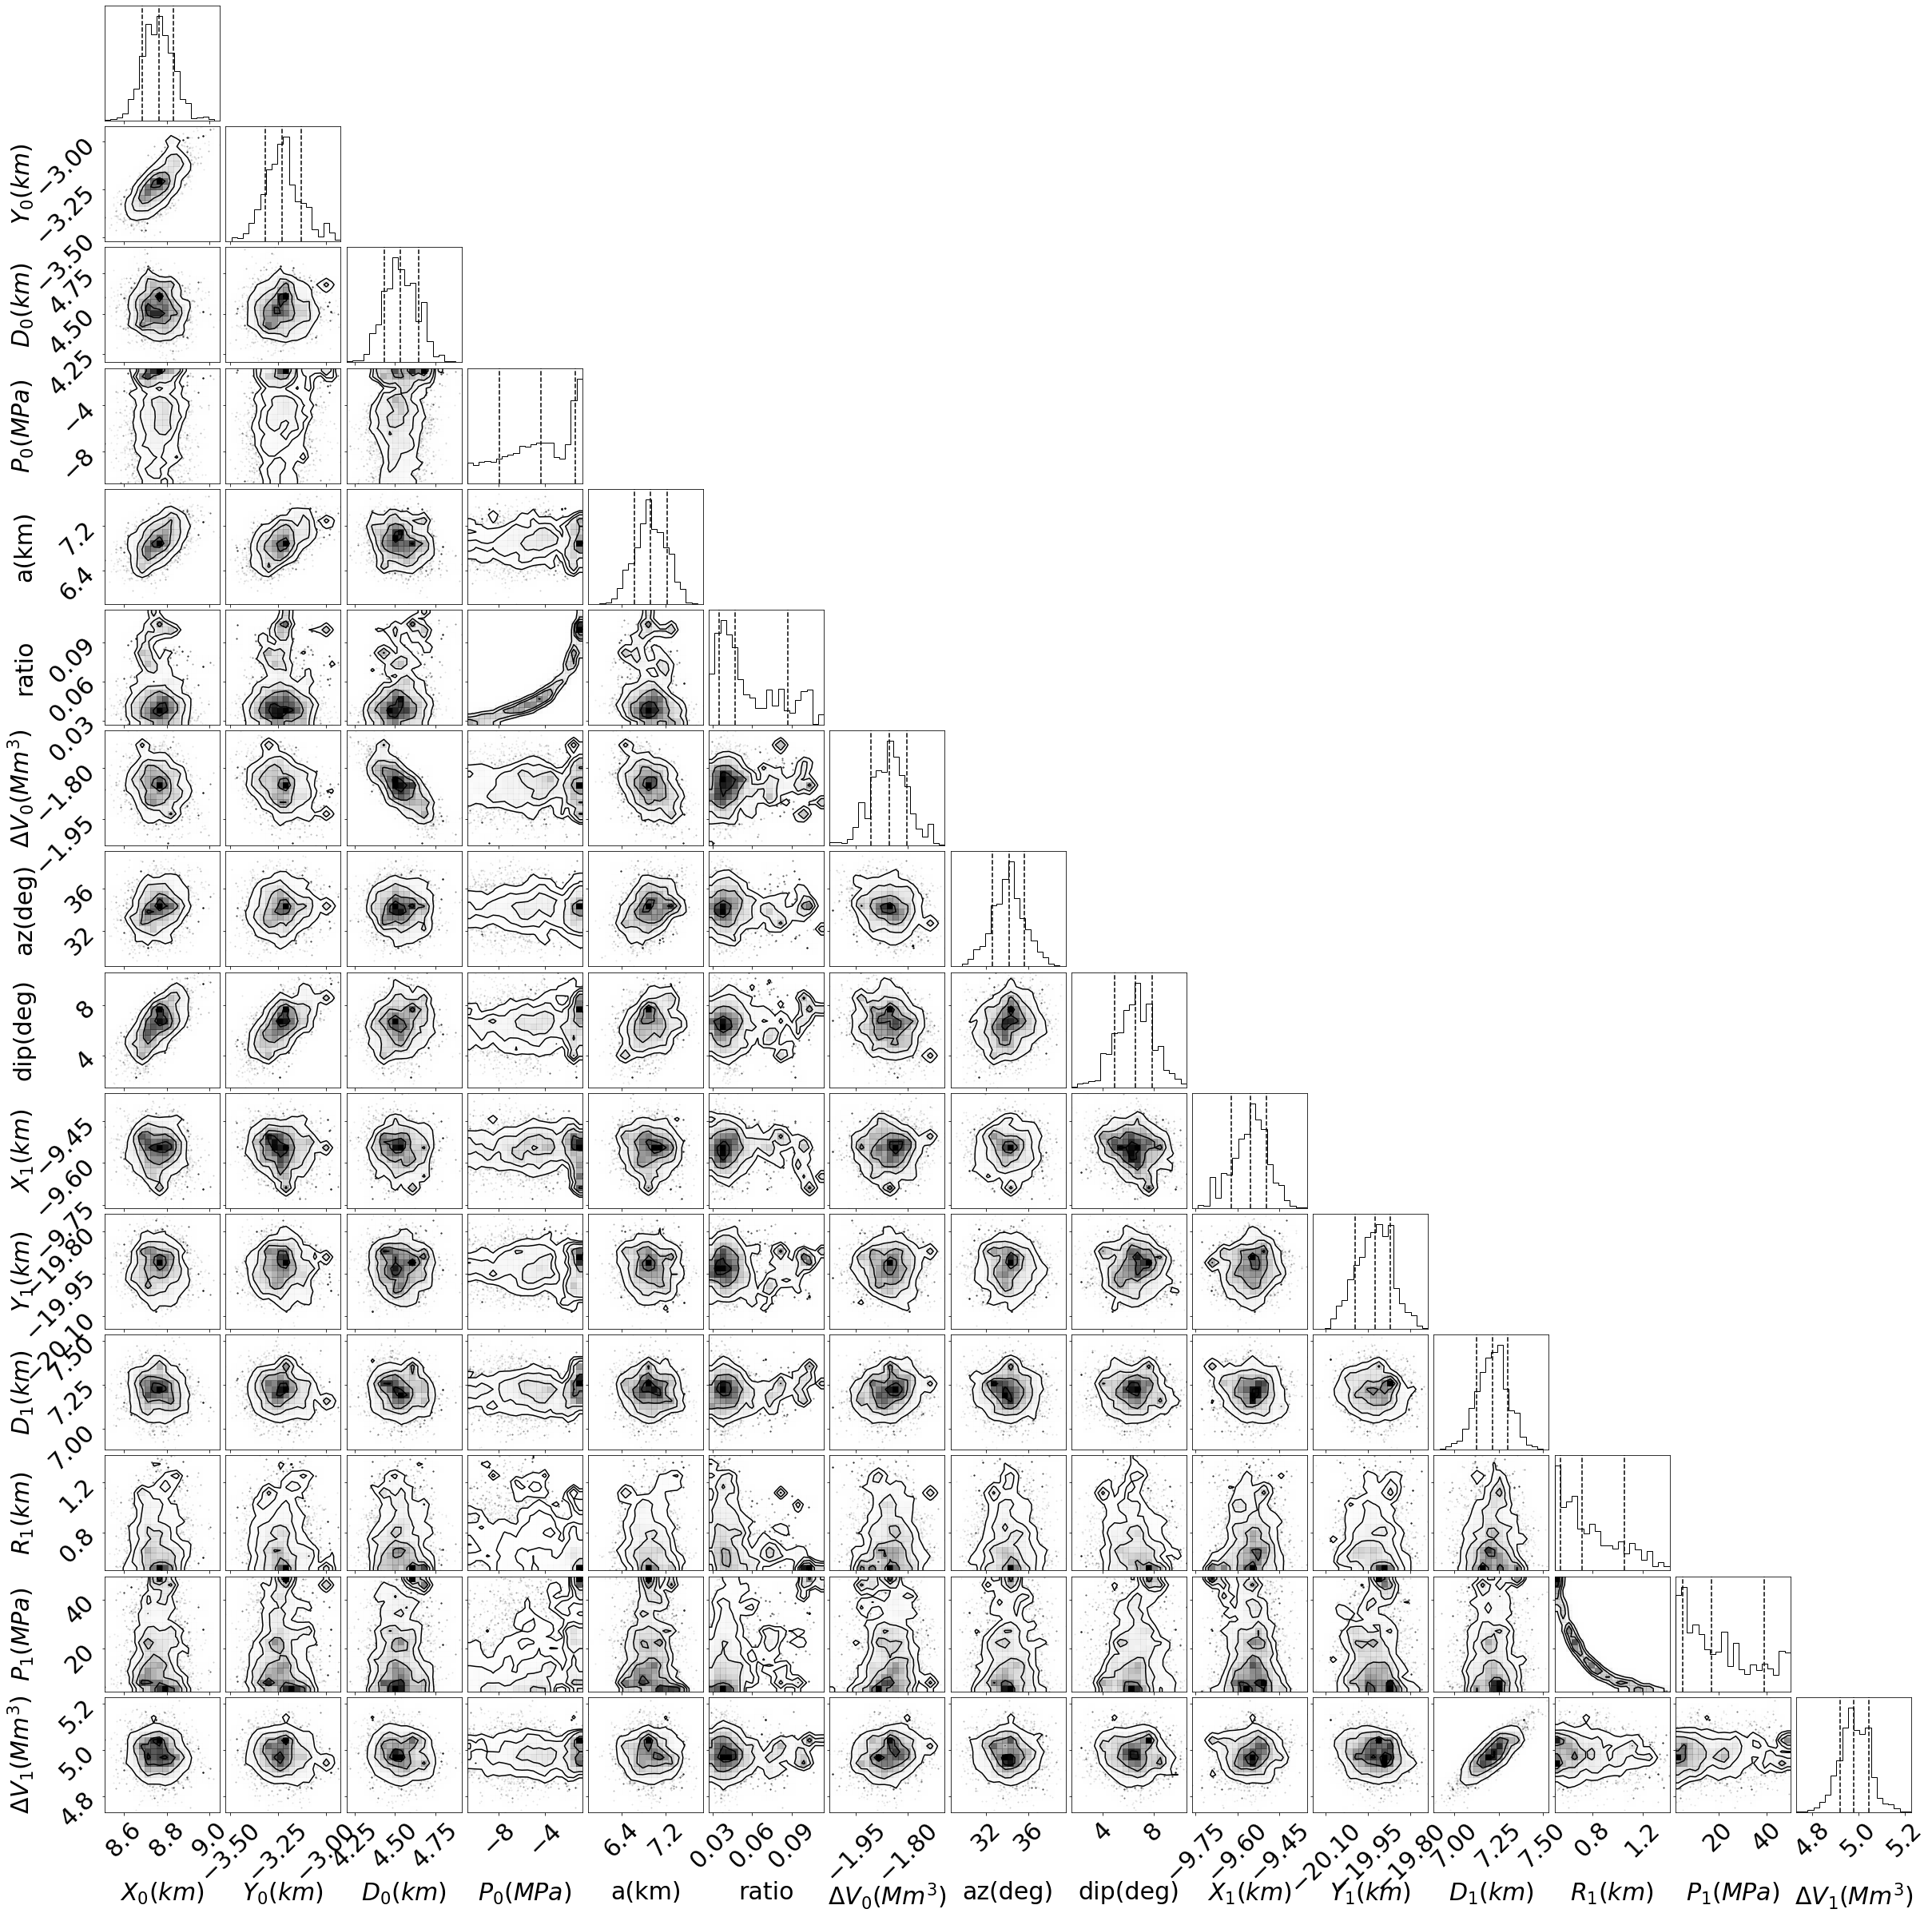

In [21]:
%matplotlib inline
data=[]
labels=[]
parnames,orders=inv.get_parnames_orders()
for i,tr in enumerate(trace):
    data.append(tr[:])
    labels.append(parnames[i])
data=np.vstack(data)

newdata=np.zeros((data.shape[0]+2,data.shape[1]))
newdata[0:5,:]=np.copy(data[0:5])
newdata[5,:]=data[5,:]/data[4,:]
newdata[6,:]=((4/3)*np.pi*data[3]*data[4,:]*data[5,:]**2/9.6e9)*((data[5,:]/data[4,:])**2/3-0.7*(data[5,:]/data[4,:])+1.37)
newdata[7:-1,:]=data[6::,:]
newdata[-1,:]=np.copy((data[-1,:]*(np.pi*data[-2,:]**3)/4e9)*(1+(data[-2,:]/data[-3,:])**4))

newdata[0:3,:]=newdata[0:3]/1e3
newdata[3,:]=newdata[3,:]/1e6
newdata[4,:]=newdata[4,:]/1e3
newdata[6,:]=newdata[6,:]/1e6
newdata[9:13,:]=newdata[9:13,:]/1e3
newdata[13::,:]=newdata[13::,:]/1e6

#labels=[r'$X_{0} (km)$',r'$Y_{0} (km)$',r'$D_{0}(km)$','$P (MPa)$','a(km)','b(km)','az(deg)','dip(deg)',r'$X_{1} (km)$',r'$Y_{1} (km)$',r'$D_{1}(km)$',r'$R_{1}(km)$',r'$V_{1}(Mm^{3})$']
newlabels=[r'$X_{0} (km)$',r'$Y_{0} (km)$',r'$D_{0}(km)$','$P_{0} (MPa)$','a(km)','ratio','$\Delta{V}_{0}(Mm^{3})$','az(deg)','dip(deg)',r'$X_{1} (km)$',r'$Y_{1} (km)$',r'$D_{1}(km)$',r'$R_{1}(km)$','$P_{1} (MPa)$',r'$\Delta{V}_{1}(Mm^{3})$']

ranges=[(10,14),(6,12),(3,8),(-100,1),(0,15),(0,0.5),(10,60),(10,70),(-7,-4),(-10,-7),(4,10),(0,5),(0,8)]

#lsans=[ans.x[0]/1e3,ans.x[1]/1e3,ans.x[2]/1e3,ans.x[3]/1e6,ans.x[4]/1e3,ans.x[5]/1e3,ans.x[6],ans.x[7],ans.x[8]/1e3,ans.x[9],ans.x[10],ans.x[11]/1e3,ans.x[12]/1e6]

plt.rcParams.update({'font.size': 30})

figure = corner.corner(newdata.T, labels=newlabels,max_n_ticks=3,smooth=0.7,labelpad=0.3,
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=False, title_kwargs={"fontsize": 30})
#corner.overplot_points(figure, np.array(lsans)[None], color="C"+str(i),marker='s')
plt.savefig('histograms')

In [22]:
xbest=np.median(data,axis=1)

bl=np.array([np.percentile(data[i,:],30) for i in range(data.shape[0])])
bh=np.array([np.percentile(data[i,:],70) for i in range(data.shape[0])])

import copy

obsn=Joint()

obs_ascn=copy.deepcopy(obsin_asc)
obs_ascn.add_err(obs_ascn.err*0+1)
obs_desn=copy.deepcopy(obsin_des)
obs_desn.add_err(obs_desn.err*0+1)

obsn.add_dataset(obs_ascn,wt=1.0)
obsn.add_dataset(obs_desn,wt=1.0)

ygn = Yang(obsn)
#yg.set_x0([8e3,-2e3,6e3,-8e6,7e3,3e2,35,20])
ygn.set_x0(xbest[0:8])
#Bounds for parameters
ygn.set_bounds(low_bounds = bl[0:8], high_bounds = bh[0:8])

mctn = Mctigue(obsn)
mctn.set_x0(xbest[8::])
#Bounds for parameters
mctn.set_bounds(low_bounds = bl[8::], high_bounds = bh[8::])

invb=Inverse(obsn)
invb.register_source(ygn)
invb.register_source(mctn)

In [23]:
ansn=invb.nlsq()
parnames,orders=invb.get_parnames_orders()
for i,parname in enumerate(parnames):
    print(parname,ansn.x[i])

0.045999471993161324
xcen0 8795.88105057808
ycen0 -3278.5411654976488
depth0 4594.318942102622
pressure0 -2107496.4660883616
a0 6972.609749782042
b0 449.22301454555003
az0 33.3711937090923
dip0 5.726901958788632
xcen1 -9584.578329944421
ycen1 -19889.33948710949
depth1 7259.39554409535
radius1 650.99343357327
dP1 22937229.6950021


xcen0 8761.733947671775
ycen0 -3227.4755883391463
depth0 4532.99680710913
pressure0 -4323125.504853963
a0 6920.6781449899845
b0 326.13743107604387
az0 34.16995967329969
dip0 6.571614774890968
xcen1 -9552.704732450078
ycen1 -19924.06284715468
depth1 7214.434130845719
radius1 718.513415504707
dP1 17020493.056337427
12.306323886436331 895


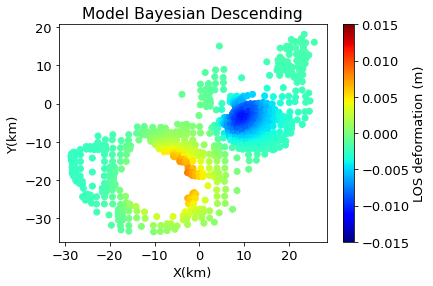

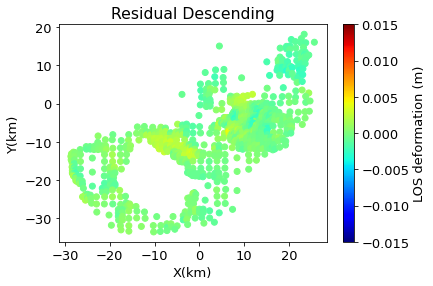

In [24]:
xbest=np.median(data,axis=1)

los_des=invin_des.forward(ansn.x)

for i,label in enumerate(labels):
    print(label,xbest[i])

plt.rcParams.update({'font.size': 13})

plt.figure()
plt.title('Model Bayesian Descending')
plt.scatter(obsin_des.xs/1e3,obsin_des.ys/1e3,c=los_des,cmap='jet',vmin=-0.015,vmax=0.015)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (m)')

plt.figure()
plt.title('Residual Descending')
plt.scatter(obsin_des.xs/1e3,obsin_des.ys/1e3,c=obsin_des.get_data()-los_des,cmap='jet',vmin=-0.015,vmax=0.015)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (m)')

print(np.sum(((obsin_des.get_data()-los_des)*1e2)**2),len(los_des))

8.853190350076371 800


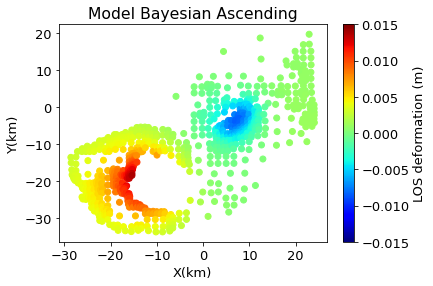

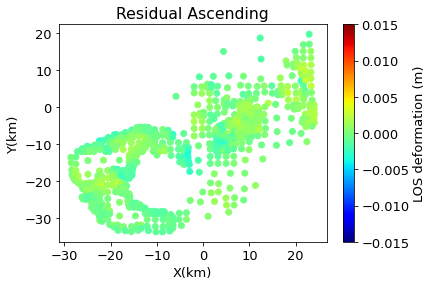

In [25]:
los_asc=invin_asc.forward(ansn.x)

plt.figure()
plt.title('Model Bayesian Ascending')
plt.scatter(obsin_asc.xs/1e3,obsin_asc.ys/1e3,c=los_asc,cmap='jet',vmin=-0.015,vmax=0.015)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (m)')

plt.figure()
plt.title('Residual Ascending')
plt.scatter(obsin_asc.xs/1e3,obsin_asc.ys/1e3,c=obsin_asc.get_data()-los_asc,cmap='jet',vmin=-0.015,vmax=0.015)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (m)')

print(np.sum(((obsin_asc.get_data()-los_asc)*1e2)**2),len(los_asc))

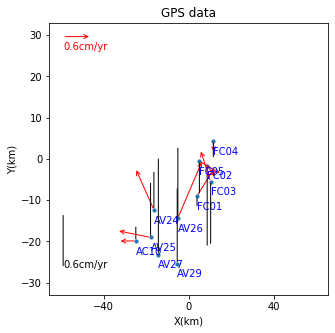

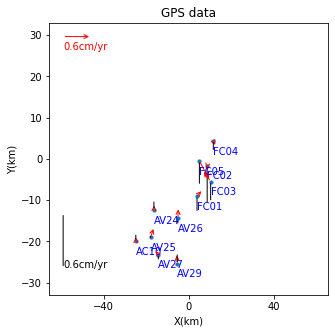

0.6312522792362407


In [26]:
%matplotlib inline
uxsm,uysm,uzsm=invg.forward(ansn.x,unravel=False)

uxs,uys,uzs=obsg.get_data(unravel=False)

util.plot_gnss(obsg.xs,obsg.ys,uxsm,uysm,uzsm,names=names,scl=0.6)
#plt.title('Model Bayesian GPS')

util.plot_gnss(obsg.xs,obsg.ys,uxs-uxsm,uys-uysm,uzs-uzsm,names=names,scl=0.6)
#plt.title('Residuals GPS')

print(np.sum((uxs*1e2-uxsm*1e2)**2+(uys*1e2-uysm*1e2)**2+(uzs*1e2-uzsm*1e2)**2))

## Save forward models from Bayesian inversion

Here we save the results from the Bayesian inversions and put them into matrices

In [27]:
util.los2npy(obsin_des.get_data(),'examples/insar/unimak_des_ref.csv',maskfile='./mask_unimak_des.npy',output='./unimak_insar_des.npy')
util.los2npy(los_des,'examples/insar/unimak_des_ref.csv',maskfile='./mask_unimak_des.npy',output='./unimak_joint_des_emc_NOAM_dP.npy')
util.los2npy(obsin_des.get_data()-los_des,'examples/insar/unimak_des_ref.csv',maskfile='./mask_unimak_des.npy',output='./unimak_joint_des_emc_res_NOAM_dP.npy')

(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 (-164.95272888220853,
  -164.06647286421406,
  54.38869946788435,
  54.92045307868102))

In [28]:
util.los2npy(obsin_asc.get_data(),'examples/insar/unimak_asc_ref.csv',maskfile='./mask_unimak_asc.npy',output='./unimak_insar_asc.npy')
util.los2npy(los_asc,'examples/insar/unimak_asc_ref.csv',maskfile='./mask_unimak_asc.npy',output='./unimak_joint_asc_emc_NOAM_dP.npy')
util.los2npy(obsin_asc.get_data()-los_asc,'examples/insar/unimak_asc_ref.csv',maskfile='./mask_unimak_asc.npy',output='./unimak_joint_asc_emc_res_NOAM_dP.npy')

(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 (-164.96499666450117,
  -164.12175031191683,
  54.38552515474153,
  54.92376750745494))

In [29]:
np.savetxt('unimak_gnss_emc_joint_NOAM_dP.txt',np.c_[names,obsg.lons,obsg.lats,uxsm,uysm,uzsm],fmt='%s')

In [30]:
np.savetxt('unimak_gnss_emc_res_joint_NOAM_dP.txt',np.c_[names,obsg.lons,obsg.lats,uxs-uxsm,uys-uysm,uzs-uzsm],fmt='%s')

In [31]:
xsf=np.array([np.percentile(data[0,:],p)+obsg.utmz[0] for p in [5,50,95]])
ysf=np.array([np.percentile(data[1,:],p)+obsg.utmz[1] for p in [5,50,95]])
xsw=np.array([np.percentile(data[8,:],p)+obsg.utmz[0] for p in [5,50,95]])
ysw=np.array([np.percentile(data[9,:],p)+obsg.utmz[1] for p in [5,50,95]])
print(obsg.utmz)
lonsf,latsf=util.utm2ll(xsf,ysf,int(obsg.utmz[2]),obsg.utmz[3])
print(lonsf[1],(lonsf[1]-lonsf[0]),(lonsf[2]-lonsf[1]))
print(latsf[1],(latsf[1]-latsf[0]),(latsf[2]-latsf[1]))
lonsw,latsw=util.utm2ll(xsw,ysw,int(obsg.utmz[2]),obsg.utmz[3])
print(lonsw[1],(lonsw[1]-lonsw[0]),(lonsw[2]-lonsw[1]))
print(latsw[1],(latsw[1]-latsw[0]),(latsw[2]-latsw[1]))

[532222.3275269632, 6061523.297986083, 3, 'U']
-164.36450405779723 0.001876995673796955 0.0018259481773270636
54.670359790232354 0.0012882163401854996 0.0017319156581621087
-164.64976805311665 0.002034432408095199 0.0015841246388959007
54.5214665845873 0.0010171947838415463 0.000865252716721443


In [32]:
for i in range(newdata.shape[0]):
    print(newlabels[i])
    if i==3:
        cons=9.6e3
    elif i==13:
        cons=4e3
    else:
        cons=1
    print((np.percentile(newdata[i,:],5)-np.percentile(newdata[i,:],50))/cons)
    print(np.percentile(newdata[i,:],50)/cons)
    print((np.percentile(newdata[i,:],95)-np.percentile(newdata[i,:],50))/cons)

$X_{0} (km)$
-0.11975527646928619
8.761733947671775
0.1160075401357279
$Y_{0} (km)$
-0.14443446209218447
-3.2274755883391464
0.1937785378964434
$D_{0}(km)$
-0.166658428814082
4.532996807109129
0.16849936267381516
$P_{0} (MPa)$
-0.0005716563428320075
-0.00045032557342228785
0.0003568321402962867
a(km)
-0.46549391447969235
6.920678144989984
0.46577759201630986
ratio
-0.016228416410400303
0.04677292738734237
0.0560310301623988
$\Delta{V}_{0}(Mm^{3})$
-0.08647118287188649
-1.8537006923620882
0.09205565890865275
az(deg)
-2.7405341573008855
34.16995967329969
2.522392372814579
dip(deg)
-2.538564741548673
6.571614774890968
2.337440515635137
$X_{1} (km)$
-0.13112297532258843
-9.552704732450078
0.1020545210820174
$Y_{1} (km)$
-0.11383633517828429
-19.92406284715468
0.09678779059020215
$D_{1}(km)$
-0.14549513403670478
7.214434130845719
0.13703525191057597
$R_{1}(km)$
-0.2056888730149916
0.718513415504707
0.5238503655876929
$P_{1} (MPa)$
-0.0034311078155060217
0.004255123264084357
0.00740026678951

In [33]:
for i in range(data.shape[0]):
    print(labels[i])
    print(np.percentile(data[i,:],5)-np.percentile(data[i,:],50))
    print(np.percentile(data[i,:],50))
    print(np.percentile(data[i,:],95)-np.percentile(data[i,:],50))

xcen0
-119.7552764692864
8761.733947671775
116.00754013572805
ycen0
-144.43446209218473
-3227.4755883391463
193.7785378964436
depth0
-166.6584288140839
4532.99680710913
168.49936267381418
pressure0
-5487900.891187272
-4323125.504853963
3425588.546844352
a0
-465.49391447969265
6920.6781449899845
465.7775920163094
b0
-110.07770051636373
326.13743107604387
387.40753971914603
az0
-2.7405341573008855
34.16995967329969
2.522392372814579
dip0
-2.538564741548673
6.571614774890968
2.337440515635137
xcen1
-131.1229753225889
-9552.704732450078
102.05452108201825
ycen1
-113.83633517828275
-19924.06284715468
96.78779059020599
depth1
-145.49513403670426
7214.434130845719
137.03525191057633
radius1
-205.6888730149916
718.513415504707
523.8503655876929
dP1
-13724431.262024084
17020493.056337427
29601067.158078123
